In [117]:
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy import interpolate
from scipy.stats import norm
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
# sys.path.append("..")

# handy it seems
# https://docs.sympy.org/latest/modules/solvers/solvers.html
from sympy.solvers import solve
from sympy import Symbol

# from analytical_option_formulae.option_types.vanilla_option import VanillaOption


# read data
df_cms_rate = pd.read_csv("../convexity_correction/df_cms_rate.csv")
df_sabr_alpha = pd.read_csv("../swaption_calibration/sabr_alpha.csv")
df_sabr_beta = pd.read_csv("../swaption_calibration/sabr_beta.csv")
df_sabr_nu = pd.read_csv("../swaption_calibration/sabr_nu.csv")
df_sabr_rho = pd.read_csv("../swaption_calibration/sabr_rho.csv")

### setup the option & sabr model ###

In [118]:
class AbstractBlack76Model:
    """
    A base class used to model Black-Scholes option model
    ...
    Parameters
    ----------
    F : float
        The forward price of the underlying asset
    K : float
        The strike price of the options
    discount_factor : float
        The "numeraire" discount factor of the model (i.e. PVBP, compounded discount factor)
    sigma : float
        Volatility
    T : float
        Maturity period (years)
    """

    def __init__(
        self,
        F: float,
        K: float,
        discount_factor: float,
        sigma: float,
        T: float,
    ):
        self.F = F
        self.K = K
        self.sigma = sigma
        self.T = T

        self.d1 = self._calculate_d1()
        self.d2 = self._calculate_d2()
        self.discount_factor = discount_factor

    def _calculate_d1(self) -> float:
        return (np.log(self.F / self.K) + self.sigma**2 / 2 * self.T) / (
            self.sigma * np.sqrt(self.T)
        )

    def _calculate_d2(self) -> float:
        return self.d1 - self.sigma * np.sqrt(self.T)


class VanillaBlack76Model(AbstractBlack76Model):
    def calculate_call_price(self) -> float:
        return self.discount_factor * (
            self.F * norm.cdf(self.d1) - self.K * norm.cdf(self.d2)
        )

    def calculate_put_price(self) -> float:
        return self.discount_factor * (
            -self.F * norm.cdf(-self.d1) + self.K * norm.cdf(-self.d2)
        )


class VanillaOption:
    def black_model(
        self, F: float, K: float, discount_factor: float, sigma: float, T: float
    ) -> VanillaBlack76Model:
        return VanillaBlack76Model(F, K, discount_factor, sigma, T)

In [119]:
# SABR
def SABR_model(F, K, T, alpha, beta, rho, nu):
    # is this what harry taught us; prevent K explosion just use 2 * of the s_nN(0)
    # K = np.min([K, F * 2])
    # K = np.min([K, 0.065])
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta) ** 2) / 24) * alpha * alpha / (F ** (2 - 2 * beta))
        numer2 = 0.25 * rho * beta * nu * alpha / (F ** (1 - beta))
        numer3 = ((2 - 3 * rho * rho) / 24) * nu * nu
        VolAtm = alpha * (1 + (numer1 + numer2 + numer3) * T) / (F ** (1 - beta))
        sabrsigma = VolAtm
    else:
        z = (nu / alpha) * ((F * X) ** (0.5 * (1 - beta))) * np.log(F / X)
        zhi = np.log((((1 - 2 * rho * z + z * z) ** 0.5) + z - rho) / (1 - rho))
        numer1 = (((1 - beta) ** 2) / 24) * ((alpha * alpha) / ((F * X) ** (1 - beta)))
        numer2 = 0.25 * rho * beta * nu * alpha / ((F * X) ** ((1 - beta) / 2))
        numer3 = ((2 - 3 * rho * rho) / 24) * nu * nu
        numer = alpha * (1 + (numer1 + numer2 + numer3) * T) * z
        denom1 = ((1 - beta) ** 2 / 24) * (np.log(F / X)) ** 2
        denom2 = (((1 - beta) ** 4) / 1920) * ((np.log(F / X)) ** 4)
        denom = ((F * X) ** ((1 - beta) / 2)) * (1 + denom1 + denom2) * zhi
        sabrsigma = numer / denom

    return sabrsigma

In [120]:
def SABR_model(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta) ** 2) / 24) * alpha * alpha / (F ** (2 - 2 * beta))
        numer2 = 0.25 * rho * beta * nu * alpha / (F ** (1 - beta))
        numer3 = ((2 - 3 * rho * rho) / 24) * nu * nu
        VolAtm = alpha * (1 + (numer1 + numer2 + numer3) * T) / (F ** (1 - beta))
        sabrsigma = VolAtm
    else:
        z = (nu / alpha) * ((F * X) ** (0.5 * (1 - beta))) * np.log(F / X)
        zhi = np.log((((1 - 2 * rho * z + z * z) ** 0.5) + z - rho) / (1 - rho))
        numer1 = (((1 - beta) ** 2) / 24) * ((alpha * alpha) / ((F * X) ** (1 - beta)))
        numer2 = 0.25 * rho * beta * nu * alpha / ((F * X) ** ((1 - beta) / 2))
        numer3 = ((2 - 3 * rho * rho) / 24) * nu * nu
        numer = alpha * (1 + (numer1 + numer2 + numer3) * T) * z
        denom1 = ((1 - beta) ** 2 / 24) * (np.log(F / X)) ** 2
        denom2 = (((1 - beta) ** 4) / 1920) * ((np.log(F / X)) ** 4)
        denom = ((F * X) ** ((1 - beta) / 2)) * (1 + denom1 + denom2) * zhi
        sabrsigma = numer / denom
    return sabrsigma

## reuse some prof tee stuff ##

In [121]:
def IRR_0(K, m, N):
    # implementation of IRR(K) function
    value = 1 / K * (1.0 - 1 / (1 + K / m) ** (N * m))
    return value


def IRR_1(K, m, N):
    # implementation of IRR'(K) function (1st derivative)
    firstDerivative = -1 / K * IRR_0(K, m, N) + 1 / (K * m) * N * m / (1 + K / m) ** (
        N * m + 1
    )
    return firstDerivative


def IRR_2(K, m, N):
    # implementation of IRR''(K) function (2nd derivative)
    secondDerivative = -2 / K * IRR_1(K, m, N) - 1 / (K * m * m) * (N * m) * (
        N * m + 1
    ) / (1 + K / m) ** (N * m + 2)
    return secondDerivative

# BEGIN PROPER #

In [122]:
print("check data, note payment_term == maturity i guess")
display(df_cms_rate)

check data, note payment_term == maturity i guess


,payment_term,cms_term,cms_rate,disc_factor,alpha,beta,rho,nu,fw_swap_rate
0,1.0,1.0,0.032104,0.997009,0.139074,0.9,-0.633223,2.049416,0.032007
1,1.0,2.0,0.033472,0.997009,0.184650,0.9,-0.525114,1.677383,0.033259
2,1.0,3.0,0.034296,0.997009,0.196852,0.9,-0.482848,1.438120,0.034011
3,1.0,5.0,0.035562,0.997009,0.178042,0.9,-0.414420,1.064975,0.035255
4,1.0,10.0,0.038972,0.997009,0.171143,0.9,-0.265908,0.777278,0.038428
5,5.0,1.0,0.040119,0.982184,0.166618,0.9,-0.585668,1.340427,0.039274
6,5.0,2.0,0.041403,0.982184,0.199534,0.9,-0.547028,1.062004,0.040075
7,5.0,3.0,0.041762,0.982184,0.210305,0.9,-0.549583,0.936601,0.040072
8,5.0,5.0,0.043068,0.982184,0.190972,0.9,-0.511010,0.672014,0.041093
9,5.0,10.0,0.047084,0.982184,0.177051,0.9,-0.438524,0.497465,0.043634


## CONTRACT NO.1 ##
the decompounded option pays the following at time T = 5y
$$
CMS 10_Y^{\frac{1}{p}} - 0.04^{\frac{1}{p}}
$$'
If i understand correctly, we should get $S_{n,N}(0)$ where the maturity is 5 years and the tenor of the option is 10 years

In [123]:
use_data = df_cms_rate.loc[df_cms_rate["payment_term"] == 5.0]
use_data = use_data.loc[use_data["cms_term"] == 10.0]

In [124]:
use_data

,payment_term,cms_term,cms_rate,disc_factor,alpha,beta,rho,nu,fw_swap_rate
9,5.0,10.0,0.047084,0.982184,0.177051,0.9,-0.438524,0.497465,0.043634


For CMS rate payment, since $g(F)=F^{1/p} - 0.04 ^{1/q}$, we have the derivatives as follows. We set $p = 4, q = 2$

In [125]:
def g_0(K):
    p = 4
    q = 2
    eq_0 = (K ** (1 / p)) - (0.04 ** (1 / q))
    return eq_0


def g_1(K):
    p = 4
    q = 2
    eq_1 = (1 / p) * (K ** ((1 / p) - 1))
    return eq_1


def g_2(K):
    p = 4
    q = 2
    eq_2 = ((1 / p) - 1) * (1 / p) * (K ** ((1 / p) - 2))
    return eq_2


def h_0(K, m, N):
    # implementation of h(K)
    value = g_0(K) / IRR_0(K, m, N)
    return value


def h_1(K, m, N):
    # implementation of h'(K) (1st derivative)
    firstDerivative = (IRR_0(K, m, N) * g_1(K) - g_0(K) * IRR_1(K, m, N)) / IRR_0(
        K, m, N
    ) ** 2
    return firstDerivative


def h_2(K, m, N):
    # implementation of h''(K) (2nd derivative)
    secondDerivative = (
        IRR_0(K, m, N) * g_2(K)
        - IRR_2(K, m, N) * g_0(K)
        - 2.0 * IRR_1(K, m, N) * g_1(K)
    ) / IRR_0(K, m, N) ** 2 + 2.0 * IRR_1(K, m, N) ** 2 * g_0(K) / IRR_0(K, m, N) ** 3
    return secondDerivative

In [126]:
def g_0(K: float) -> float:
    p = 4
    q = 2
    return K ** (1 / p) - 0.04 ** (1 / q)


def g_1(K: float) -> float:
    p = 4
    q = 2
    return (1 / p) * K ** (1 / p - 1)


def g_2(K: float) -> float:
    p = 4
    q = 2
    return (1 / p) * (1 / p - 1) * K ** (1 / p - 2)

In [127]:
# setup vanilla option
vanilla_option = VanillaOption()

In [128]:
def v_payer(discount_factor, F, K, sigma, expiry, payment_freq, tenor):
    b76_model = vanilla_option.black_model(F, K, 1, sigma, expiry)
    return (
        discount_factor
        * IRR_0(F, payment_freq, tenor)
        * b76_model.calculate_call_price()
    )


def v_receiver(discount_factor, F, K, sigma, expiry, payment_freq, tenor):
    b76_model = vanilla_option.black_model(F, K, 1, sigma, expiry)  # IRR NUMERAIRE

    return (
        discount_factor
        * IRR_0(F, payment_freq, tenor)
        * b76_model.calculate_put_price()
    )

In [129]:
# def integ_receiver_func(K, discount_factor, F, sabr_sigma, expiry, payment_freq, tenor):
#    return v_receiver(discount_factor, F, K, sabr_sigma, expiry, payment_freq, tenor)


# ef integ_payer_func(K, discount_factor, F, sabr_sigma, expiry, payment_freq, tenor):
#    return v_payer(discount_factor, F, K, sabr_sigma, expiry, payment_freq, tenor)

In [130]:
use_data

,payment_term,cms_term,cms_rate,disc_factor,alpha,beta,rho,nu,fw_swap_rate
9,5.0,10.0,0.047084,0.982184,0.177051,0.9,-0.438524,0.497465,0.043634


In [131]:
F = use_data["fw_swap_rate"].values[0]
disc_factor = use_data["disc_factor"].values[0]
alpha = use_data["alpha"].values[0]
beta = use_data["beta"].values[0]
rho = use_data["rho"].values[0]
nu = use_data["nu"].values[0]

In [132]:
def calculate_contract_price_1(F, expiry, tenor, payment_freq):
    first_term = disc_factor * g_0(F)

    # receiver integ
    second_term = quad(
        lambda x: h_2(x, payment_freq, tenor)
        * v_receiver(
            disc_factor,
            F,
            x,
            SABR_model(F, x, expiry, alpha, beta, rho, nu),
            expiry,
            payment_freq,
            tenor,
        ),
        0,
        F,
    )
    second_term = second_term[0]

    # third integ
    third_term = quad(
        lambda x: h_2(x, payment_freq, tenor)
        * v_payer(
            disc_factor,
            F,
            x,
            SABR_model(F, x, expiry, alpha, beta, rho, nu),
            expiry,
            payment_freq,
            tenor,
        ),
        F,
        float("inf"),
    )
    third_term = third_term[0]
    print(f"{expiry} {tenor}")
    print(f"{alpha} {beta} {rho} {nu}")
    print(f"{disc_factor} {F} {first_term} {second_term} {third_term}")

    sum = first_term + second_term + third_term
    return sum

In [133]:
calculate_contract_price_1(F=F, expiry=5.0, tenor=10.0, payment_freq=2.0)

5.0 10.0
0.1770511058952744 0.9 -0.4385244687528474 0.4974650377474459
0.9821841197332212 0.0436336455201687 0.25246180899017634 -0.022708004074910783 0.003039761313828754


C:\Users\kilo\AppData\Local\Temp\ipykernel_20840\4053913546.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  second_term = quad(


0.2327935662290943

## CONTRACT NO.2 ##
the decompounded option pays the following at time T = 5y
$$
max(CMS 10_Y^{\frac{1}{p}} - 0.04^{\frac{1}{q}},0)
$$'
If i understand correctly, we should get $S_{n,N}(0)$ where the maturity is 5 years and the tenor of the option is 10 years

In [134]:
# check first, maybe we can simplify some things
p = 4
q = 2
underlying = F ** (1 / p)
strike = 0.04 ** (1 / q)
if underlying > strike:
    print(f"{underlying} > {strike}")

0.457041224672569 > 0.2


We can play around with this. 

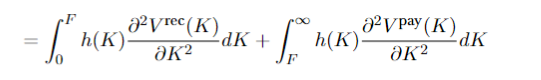

We can maybe play around with the limits of integration, from the above check we can see that 
$$
F ^{1/4} > 0.04 ^ {1/2} \\
F > 0.04 ^ 2
$$
We can try setting the limits of integration $L = 0.04^2 = 16 \times 10^{-4}$. If you check the docs for CMS replication, we get the following formula

$$
V(0) = h'(L) V_{pay}(L) + \int_{L}^{\infty} h''(K)V_{pay}(K) dK
$$

In [135]:
L = 0.04 ** (p / q)

In [136]:
def calculate_contract_price_2(F, L, expiry, tenor, payment_freq):
    first_term = h_1(L, 2, 10) * v_payer(
        disc_factor,
        F,
        L,
        SABR_model(F, L, expiry, alpha, beta, rho, nu),
        expiry,
        payment_freq,
        tenor,
    )
    second_term = quad(
        lambda x: h_2(x, payment_freq, tenor)
        * v_payer(
            disc_factor,
            F,
            x,
            SABR_model(F, x, expiry, alpha, beta, rho, nu),
            expiry,
            payment_freq,
            tenor,
        ),
        F,
        float("inf"),
    )[0]
    return first_term + second_term

In [137]:
calculate_contract_price_2(F, L, 5, 10, 2)

1.0509369658385335